# Flat Image Net - Evaluate Results

 - inspect predictions
 - inspect info df with imgs
 - get recall and accuracy
 - false positives predicted class name
 - coocurance log

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import os
import shutil
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from utils.data import init_dir

## Load data

In [3]:
data = input_data.read_data_sets('/data/fashion/', one_hot=True)
class_id2class_name_mapping = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'}

Extracting /data/fashion/train-images-idx3-ubyte.gz
Extracting /data/fashion/train-labels-idx1-ubyte.gz
Extracting /data/fashion/t10k-images-idx3-ubyte.gz
Extracting /data/fashion/t10k-labels-idx1-ubyte.gz


## Build Net Graph

In [4]:
from utils.nn_graph import simple_layer
from utils.nn_visualization import variable_summaries, img_summaries

graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('flat_image_net_inputs'):
        images = tf.placeholder(tf.float32, shape=[None, 784], name='images')
        labels = tf.placeholder(tf.float32, shape=[None, 10], name='labels')
    
    with tf.variable_scope('simple_layer_1'):
        raw_prediction = simple_layer(name='layer1', input_data=images, shape=[784, 64], activation='relu')
        
    with tf.variable_scope('simple_layer_2'):
        raw_prediction = simple_layer(name='layer2', input_data=raw_prediction, shape=[64, 10])
            
    with tf.name_scope('prediction'):
        prediction = tf.nn.softmax(raw_prediction)
    
    with tf.name_scope('loss'):
        cross_entropy_vector = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=prediction)
        loss = tf.reduce_mean(cross_entropy_vector)
        variable_summaries('loss_summary', loss)

    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        accuracy = tf.reduce_mean(correct_prediction)
        variable_summaries('accuracy_summary', correct_prediction)       
        
    with tf.name_scope('training'):
        train_step = tf.train.AdamOptimizer(0.001).minimize(loss)
            
    initialize_vars = tf.global_variables_initializer()
    merge_summaries = tf.summary.merge_all()

## Init Model Logging

In [5]:
from utils.data import init_model_logging
base_dir = '/tensorboard_summaries/flat_image_net/'

logging_meta = init_model_logging(base_dir, 'experiment_model_eval', graph=graph, remove_existing=True)

## Run Net

In [6]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
model_path = logging_meta['model_path']
        
with tf.Session(graph=graph, config=config) as session:
    session.run(initialize_vars)
    for iteration in range(20000):
        _images, _labels = data.train.next_batch(100)
        
        _ = session.run([train_step], feed_dict={images: _images, labels: _labels})
        if iteration % 10 == 0:
            _summary, = session.run([merge_summaries],feed_dict={images: _images, labels: _labels})
            logging_meta['train_writer'].add_summary(_summary, iteration)
            
        if iteration % 100 == 0:
            _summary, _accuracy, _loss = session.run([merge_summaries, accuracy, loss], 
                                          feed_dict={images: data.validation.images, 
                                                     labels: data.validation.labels})
            logging_meta['valid_writer'].add_summary(_summary, iteration)
            logging_meta['saver'].save(session, model_path, iteration)
            print("Iteration {}: loss {}, accuracy {}".format(iteration, _loss, _accuracy))
            
    _prediction, = session.run([prediction], feed_dict={images: data.validation.images})

Iteration 0: loss 2.271357536315918, accuracy 0.31200000643730164
Iteration 100: loss 1.8093215227127075, accuracy 0.6805999875068665
Iteration 200: loss 1.7547496557235718, accuracy 0.7296000123023987
Iteration 300: loss 1.7105495929718018, accuracy 0.7684000134468079
Iteration 400: loss 1.6740238666534424, accuracy 0.798799991607666
Iteration 500: loss 1.6667051315307617, accuracy 0.803600013256073
Iteration 600: loss 1.662092924118042, accuracy 0.8076000213623047
Iteration 700: loss 1.6606934070587158, accuracy 0.8065999746322632
Iteration 800: loss 1.6596808433532715, accuracy 0.807200014591217
Iteration 900: loss 1.6526894569396973, accuracy 0.8158000111579895
Iteration 1000: loss 1.6510484218597412, accuracy 0.817799985408783
Iteration 1100: loss 1.6510590314865112, accuracy 0.8158000111579895
Iteration 1200: loss 1.650946855545044, accuracy 0.8148000240325928
Iteration 1300: loss 1.6494847536087036, accuracy 0.8145999908447266
Iteration 1400: loss 1.639954686164856, accuracy 0.8

Iteration 12000: loss 1.5791648626327515, accuracy 0.883400022983551
Iteration 12100: loss 1.5792492628097534, accuracy 0.8841999769210815
Iteration 12200: loss 1.5802186727523804, accuracy 0.881600022315979
Iteration 12300: loss 1.5786218643188477, accuracy 0.8822000026702881
Iteration 12400: loss 1.579576015472412, accuracy 0.8831999897956848
Iteration 12500: loss 1.5798345804214478, accuracy 0.883400022983551
Iteration 12600: loss 1.5775011777877808, accuracy 0.883400022983551
Iteration 12700: loss 1.5777599811553955, accuracy 0.8822000026702881
Iteration 12800: loss 1.5861619710922241, accuracy 0.8754000067710876
Iteration 12900: loss 1.5750060081481934, accuracy 0.8873999714851379
Iteration 13000: loss 1.5781222581863403, accuracy 0.8827999830245972
Iteration 13100: loss 1.577652096748352, accuracy 0.8830000162124634
Iteration 13200: loss 1.57566237449646, accuracy 0.8849999904632568
Iteration 13300: loss 1.5777918100357056, accuracy 0.8827999830245972
Iteration 13400: loss 1.5773

In [10]:
_prediction

array([[  3.23238344e-26,   1.70910973e-30,   3.70421404e-30, ...,
          7.92642336e-15,   5.97072625e-16,   1.00000000e+00],
       [  1.00000000e+00,   1.08329177e-25,   5.79247534e-18, ...,
          6.70139338e-33,   2.25491990e-22,   3.53052356e-26],
       [  9.11691070e-01,   5.04949479e-04,   1.02292502e-03, ...,
          3.11877923e-09,   8.07674372e-10,   6.98475517e-08],
       ..., 
       [  1.96801253e-07,   4.42843939e-12,   1.08188314e-09, ...,
          1.30741691e-05,   7.92182709e-06,   1.08697141e-05],
       [  4.88103007e-14,   4.61292184e-16,   2.45196663e-08, ...,
          2.98026664e-33,   1.00000000e+00,   1.13789334e-27],
       [  6.26490637e-09,   2.84092636e-07,   7.68598873e-09, ...,
          1.35160532e-13,   8.72221584e-09,   3.03041792e-09]], dtype=float32)

## Load reuslts to pandas df

In [22]:
from utils.results_evaluation import get_info_df

df = get_info_df(data.validation.labels, _prediction, class_id2class_name_mapping, images=data.validation.images)
df

,image,label_class_name,label_class_score,predicted_class_name_top1,predicted_class_name_top3,predicted_class_score_top1,predicted_class_score_top3
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Ankle boot,1.000000e+00,Ankle boot,Ankle boot,1.000000,1.000000e+00
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.00392157, 0.0, 0.0...",T-shirt/top,1.000000e+00,T-shirt/top,T-shirt/top,1.000000,1.000000e+00
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",T-shirt/top,9.943024e-01,T-shirt/top,T-shirt/top,0.994302,9.943024e-01
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.129...",Dress,8.002167e-01,Dress,Dress,0.800217,8.002167e-01
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",T-shirt/top,5.081260e-01,T-shirt/top,T-shirt/top,0.508126,5.081260e-01
5,"[0.0, 0.0, 0.0, 0.0, 0.00392157, 0.0, 0.0, 0.0...",Pullover,1.000000e+00,Pullover,Pullover,1.000000,1.000000e+00
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Sneaker,1.000000e+00,Sneaker,Sneaker,1.000000,1.000000e+00
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.00392157, 0.003921...",Pullover,9.944781e-01,Pullover,Pullover,0.994478,9.944781e-01
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Sandal,1.000000e+00,Sandal,Sandal,1.000000,1.000000e+00
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Sandal,1.000000e+00,Sandal,Sandal,1.000000,1.000000e+00


In [23]:
df.columns

Index(['image', 'label_class_name', 'label_class_score',
       'predicted_class_name_top1', 'predicted_class_name_top3',
       'predicted_class_score_top1', 'predicted_class_score_top3'],
      dtype='object')

## Recall

In [24]:
def get_recall(df, class_name):
    true_positives = len(df[(df.label_class_name==class_name) & (df.predicted_class_name_top1==class_name)])
    trues = len(df[(df.label_class_name==class_name)])
    return round(true_positives / trues * 100, 2)

In [25]:
get_recall(df, 'T-shirt/top')

96.06

## Precision

In [26]:
def get_precision(df, class_name):
    true_positives = len(df[(df.label_class_name==class_name) & (df.predicted_class_name_top1==class_name)])
    positives = len(df[(df.predicted_class_name_top1==class_name)])
    if positives == 0:
        positives = 1
    return round(true_positives / positives * 100, 2)

In [27]:
get_precision(df, 'T-shirt/top')

65.92

## Accuracy

In [28]:
def get_accuracy(df):
    return round(float(np.mean((df.label_class_name == df.predicted_class_name_top1).astype(int))) * 100, 2)

In [29]:
get_accuracy(df)

83.94

## Overall Recall and Precision

In [30]:
def get_rec_prec(df, class_id2class_name_mapping):
    return pd.DataFrame(
        {
            "class_name": [class_name for class_name in class_id2class_name_mapping.values()],
            "recall": [get_recall(df, class_name) for class_name in class_id2class_name_mapping.values()],
            "precision": [get_precision(df, class_name) for class_name in class_id2class_name_mapping.values()]
        })

In [31]:
get_rec_prec(df, class_id2class_name_mapping).sort_values(by='recall')

,class_name,precision,recall
6,Shirt,0.00,0.00
2,Pullover,73.64,80.36
4,Coat,61.07,86.48
3,Dress,88.19,92.42
5,Sandal,97.91,95.13
7,Sneaker,93.69,95.70
0,T-shirt/top,65.92,96.06
9,Ankle boot,95.32,96.64
8,Bag,94.44,97.14
1,Trouser,99.09,97.84


## False Positives

In [32]:
def get_false_positives(df, label_class_name, predicted_class_name=None):
    if predicted_class_name is None:
        condition = (df['label_class_name']==label_class_name) & (df['predicted_class_name_top1']!=label_class_name)
    else:
        condition = (df['label_class_name']==label_class_name) & (df['predicted_class_name_top1']==predicted_class_name)
    return df[condition].sort_values(by='predicted_class_score_top1', ascending=False)

In [33]:
fp = get_false_positives(df, 'Shirt')
fp

,image,label_class_name,label_class_score,predicted_class_name_top1,predicted_class_name_top3,predicted_class_score_top1,predicted_class_score_top3
18,"[0.0, 0.0, 0.0, 0.00784314, 0.0, 0.00784314, 0...",Shirt,8.582156e-22,Pullover,Bag,1.000000,1.254992e-10
1978,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Shirt,4.567043e-18,T-shirt/top,Bag,1.000000,3.189840e-12
1790,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Shirt,9.846843e-31,T-shirt/top,Pullover,1.000000,1.570838e-18
4028,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Shirt,5.123104e-26,Pullover,Bag,1.000000,1.142124e-09
1830,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.231373, ...",Shirt,4.944513e-29,Pullover,Trouser,1.000000,2.335022e-17
1840,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.086...",Shirt,1.855091e-18,T-shirt/top,Pullover,1.000000,7.897559e-10
1849,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.149...",Shirt,1.642450e-38,T-shirt/top,Dress,1.000000,4.272118e-16
4023,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00392157, 0.0...",Shirt,0.000000e+00,T-shirt/top,Dress,1.000000,9.008984e-24
1863,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Shirt,5.789156e-20,T-shirt/top,Pullover,1.000000,6.613616e-13
4015,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00392157, 0.0...",Shirt,8.429097e-25,T-shirt/top,Coat,1.000000,2.540450e-14


In [34]:
def plot_examples(df, img_shape=(28, 28)):
    examples_count = min(25, len(df))
    cols = 5
    rows = np.ceil(examples_count / cols)
    
    fig = plt.figure(figsize=(20,25))
    for img_id in range(examples_count):
        ax = plt.subplot(rows, cols, img_id+1)

        img = df.image.iloc[img_id]
        if img is None:
            continue
        img = img.reshape(img_shape)
        prediction_name = df.predicted_class_name_top1.iloc[img_id]
        prediction_score = df.predicted_class_score_top1.iloc[img_id]

        ax.imshow(img , cmap='gray')
        ax.set_title("{0}: {1}".format(prediction_name, round(prediction_score, 2)))
        ax.axes.set_axis_off()

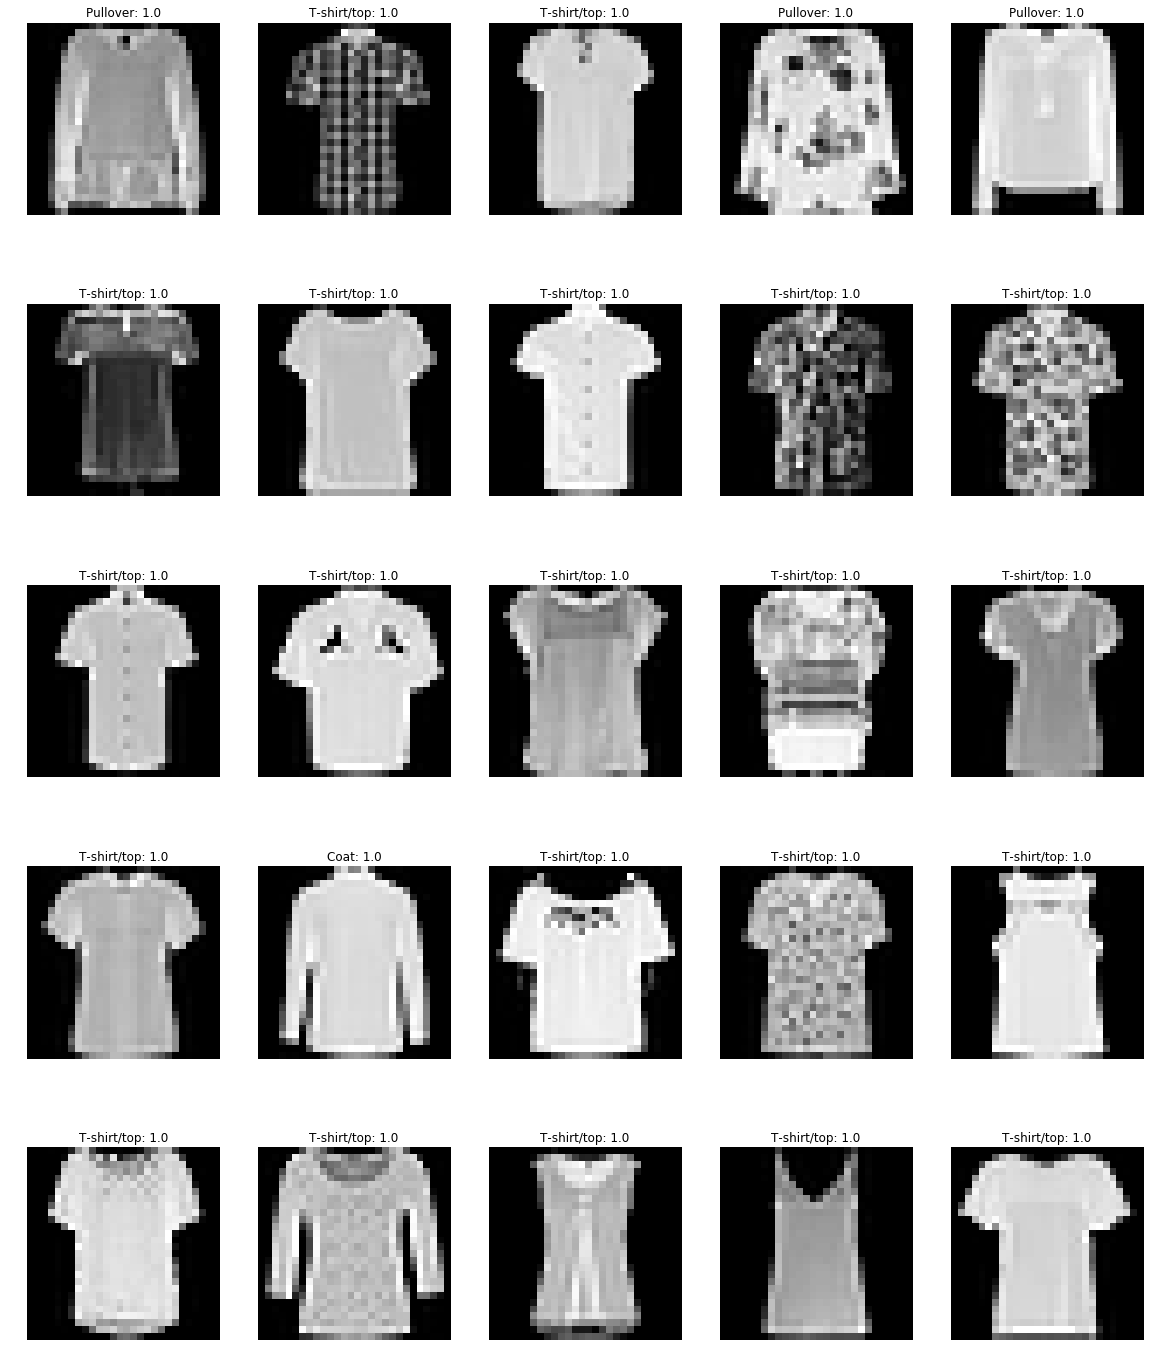

In [35]:
plot_examples(fp)

## Coocurance matrix

In [36]:
def plot_coocurance_matrix(df, use_log=False, use_top3=False):
    if use_top3:
        coocurance_cols = ['label_class_name', 'predicted_class_name_top3']
    else:
        coocurance_cols = ['label_class_name', 'predicted_class_name_top1']
    coocurance_df = pd.pivot_table(df[coocurance_cols], index=coocurance_cols[0], 
                                   columns=coocurance_cols[1], aggfunc=len, fill_value=0)
    if use_log:
        coocurance_df = np.log(coocurance_df)
        coocurance_df = coocurance_df.replace([-np.inf], 0)

    coocurance_df = coocurance_df.div(coocurance_df.sum(axis=1), axis=0) * 100
    coocurance_df = coocurance_df.round(2)
    
    fig = plt.figure(figsize=(10,10))
    ax = plt.gca()
    sns.heatmap(coocurance_df, ax=ax, annot=True,  linewidths=.5, 
                cbar_kws={"orientation": "horizontal"}, cmap="YlGnBu")

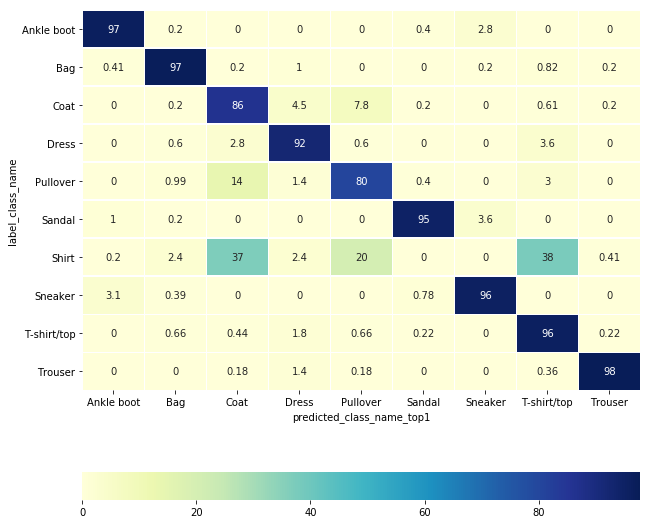

In [38]:
plot_coocurance_matrix(df, use_log=False)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


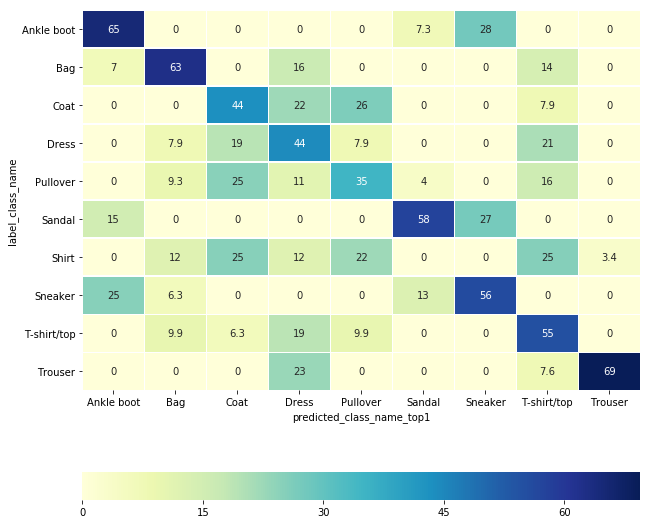

In [39]:
plot_coocurance_matrix(df, use_log=True)